# 导入包和设置全局路径

In [1]:
import os
import zipfile
import lxml.etree as etree
import shutil
import numpy as np
import pandas as pd
import re
import pdb

In [2]:
import sklearn.preprocessing

In [9]:
from sklearn.decomposition import PCA

In [110]:
from sklearn.cluster import KMeans

In [6]:
import seaborn as sns

In [7]:
import matplotlib.pyplot as plt

###### 设置路径

In [10]:
strJobsDir = "../jobs_notest"
strZipsDir = "../zips"

# 工具函数

In [11]:
#通过输入的任务文件夹返回任务文件夹中的所有解调器文件夹路径
def fn_getDemodDirsOfAJob(strJobDir):
    liststrDemodDirs = [os.path.join(strJobDir, strName) for strName in os.listdir(strJobDir) if "Demod" in strName]
    return liststrDemodDirs

# 读入任务配置文件

## 读入任务计划文件

首先清空jobs文件夹。\
WorkSch文件中存放了提前计算出的预计接收开始和结束时间。需利用这个接收开始和结束时间截取出有效时间段。\
可能有多个WorkSch文件，根据它的createdTime选择最新的WorkSch文件。

In [22]:
if os.path.exists(strJobsDir):
    shutil.rmtree(strJobsDir)
os.mkdir(strJobsDir)
for strZipFileName in os.listdir(strZipsDir):
    pdTimestampNewestCreated = pd.Timestamp("1970-1-1")
    strJobDir = os.path.join(strJobsDir, os.path.splitext(strZipFileName)[0])
    os.mkdir(strJobDir)
    strZipFile = os.path.join(strZipsDir, strZipFileName)
    with zipfile.ZipFile(strZipFile) as oZipFile:
        for strFile in oZipFile.namelist():
            if "WorkSch_TASK" in strFile:
                strWorkSchFile = os.path.join(strJobDir, "work_sch.xml")
                with oZipFile.open(strFile) as f:
                    oElementTree = etree.parse(f)
                    # f 文件对象只能在parse中使用一次
                    # 找到文件创建时间
                    pdTimestampCreated = pd.Timestamp(
                            oElementTree.find("./fileHeader/createdTime").text)
                    if pdTimestampCreated > pdTimestampNewestCreated:
                    # 提取最新的文件
                        pdTimestampNewestCreated = pdTimestampCreated
                        oElementTree.write(strWorkSchFile)

## 读入设备列表文件
任务所用的所有设备都在列表文件里。要根据文件中对设备状态文件的属于的设备的描述提取出用于数据接收传输的设备状态文件。

In [23]:
for strZipFileName in os.listdir(strZipsDir):
    strJobDir = os.path.join(strJobsDir, os.path.splitext(strZipFileName)[0])
    strZipFile = os.path.join(strZipsDir, strZipFileName)
    with zipfile.ZipFile(strZipFile) as oZipFile:
        for strFile in oZipFile.namelist():
            if "DeviceList" in strFile:
                strDeviceListFile = os.path.join(strJobDir, "device_list.xml")
                with oZipFile.open(strFile) as f:
                    with open(strDeviceListFile, "wb") as f1:
                        f1.write(f.read())

# 解调器预处理描述

1. 根据任务的设备列表文件找到解调器的设备ID
2. 利用设备ID找到解调器的设备状态文件和控制文件，并保存
3. 从任务的任务计划文件中读出接收的开始和结束时间，利用接收时间段截取出有效时间段内的记录
4. 将解调器的状态参数按照信号处理流程划分为数个最小模块
5. 针对每个最小模块产生训练样本和测试样本

# 载入设备状态文件和控制文件

1. 清空原有的设备文件夹。
2. 在设备列表文件中找到解调器设备ID
3. 将相应设备状态文件载入设备文件夹

执行完成后，任务文件夹里多出如下文件：
* 任务名/
    * 解调器名/
        * raw/
            * status.csv
        * control.csv

In [43]:
# 从zip文件中解压缩具有设备的状态文件，存入raw
def fn_extractFilesFromAZip(strJobDir, strID, strZipFile):
    strZipDemodStatusFile = "Status_" + strID
    with zipfile.ZipFile(strZipFile) as oZipFile:
        for strFile in oZipFile.namelist():
            # 迭代找到zip文件里的解调器的状态文件和控制参数文件
            if "Status_" + strID in strFile:
                # 状态文件
                with oZipFile.open(strFile) as f:
                    with open(os.path.join(strJobDir, strID + "/raw/status.csv"), "wb") as f1:
                        f1.write(f.read())
            elif "Control_" + strID in strFile:
                # 控制文件
                with oZipFile.open(strFile) as f:
                    with open(os.path.join(strJobDir, strID + "/control.csv"), "wb") as f1:
                        f1.write(f.read())

for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    # 删除原有的解调器文件夹
    for strName in os.listdir(strJobDir):
        if "Demod" in strName:
            strDemodDir = os.path.join(strJobDir, strName)
            shutil.rmtree(strDemodDir)
    
    strZipFile = os.path.join(strZipsDir, strJob + ".zip")
    strDeviceListFile = os.path.join(strJobDir, "device_list.xml")
    oElementTree = etree.parse(strDeviceListFile)
    listDevElement = oElementTree.findall("./content/deviceList/Device")
    for oElement in listDevElement:
        strID = oElement.find("DevID").text
        if "Demod" in strID:
            # 新建解调器文件raw文件夹
            os.makedirs(os.path.join(strJobDir, strID + "/raw"))
            fn_extractFilesFromAZip(strJobDir, strID, strZipFile)

# 解调器属性选取（更新）

检查所有的解调器状态文件发现，以下属性不是所有的解调器都存在：

DEMOD_PHASEROTATION，GLOBAL_DEMOD1STATUS，GLOBAL_TEMPSTATUS，DRU_DISKSPACE1，DRU_USEDSPACE1，DRU_FREESPACE1，DRU_USEDPERCENT1

对它们进行忽略。

目前发现的在数据集中的值只有一种的属性也全部忽略。以后可能会发现它们有多种值。

解调器的状态参数按照参数名的前缀来划分大致有3类——DPU（data packet unit），DEMOD、IFU(中频控制单元)，DRU。


下面的函数完成的功能如下：
* 输入查询的状态参数名称，以字符串形式返回数据集中该参数所具有的所有值组成的集合
* 输入任务设定的参数名和对应的值，返回其它任务设定参数的值和该值的对应关系

In [4]:
# 查询的状态参数所有可能值
def fn_getValuesInStr(strFeature):
    setCat = set()
    for strJob in os.listdir(strJobsDir):
        strJobDir = os.path.join(strJobsDir, strJob)
        listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
        for strDemodDir in listDemodDirs:
            try:
                pdDfValidStatus = pd.read_csv(os.path.join(strDemodDir, "valid/status.csv"), index_col="RECTIME")
                for r in pdDfValidStatus.loc[:, strFeature]:
                    setCat.add(r)
            except:
                # 如果该文件里没有查询的参数名，输出文件名
                print(strDemodDir)
    return str(setCat)

# 输出参数具有某一个值的解调器文件夹
def fn_getDirOfAValue(strFeature, value):
    for strJob in os.listdir(strJobsDir):
        listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
        for strDemodDir in listDemodDirs:
            pdDfValidStatus = pd.read_csv(os.path.join(strDemodDir, "valid/status.csv"), index_col="RECTIME")
            if value in list(pdDfValidStatus.loc[:, strFeature]):
                return strDemodDir

In [5]:
fn_getValuesInStr("DEMOD_CARRIERLOCK")

'{1, 2}'

In [10]:
fn_getDirOfAValue("DPU_RSENABLE1", 1)

'../jobs\\JOB201912276594418\\KJ_HDemodQH1'

# 截取出有效接收时间范围内的记录

1. 首先清空每个解调器文件夹下的valid文件夹
2. 然后从work_sch.xml文件中读入数据接收的有效时间段
3. 根据有效时间段截取每个解调器的设备状态文件的有效记录，存入valid文件夹
执行完成后，任务文件里多出了如下文件：
* 任务名/
    * 解调器名/
        * valid/
            * status.csv

从指定任务文件夹中读取任务所使用的解调器名

In [181]:
# 从任务文件夹中提取计划的接收任务开始时间和结束时间
def fn_getValidPeriod(strJobDir):
    strWorkSchFile = os.path.join(strJobDir, "work_sch.xml")
    oElementTree = etree.parse(strWorkSchFile)
    strReceivingStartTime = "./content/equipmentInfo/receivingStartTime"
    strReceivingEndTime = "./content/equipmentInfo/receivingEndTime"
    pdTimestampStart = pd.Timestamp(oElementTree.find(strReceivingStartTime).text)
    pdTimestampEnd = pd.Timestamp(oElementTree.find(strReceivingEndTime).text)
    return pdTimestampStart, pdTimestampEnd

# 利用任务的计划接收开始和结束时间截取解调器的有效状态
def fn_extractValidRecordsOfRawStatus(pdTimestampStart, pdTimestampEnd, strStatusDir):
    strValidStatusDir = os.path.join(strStatusDir, "valid")
    if os.path.exists(strValidStatusDir):
            shutil.rmtree(strValidStatusDir)
    os.mkdir(strValidStatusDir)

    strRawStatusFile = os.path.join(strStatusDir, "raw/status.csv")
    pdDfRawStatus = pd.read_csv(strRawStatusFile, index_col="RECTIME")
    pdSeriesFilter = pd.Series(data=pdDfRawStatus.index)
    pdSeriesFilter = pdSeriesFilter.apply(lambda t: pd.Timestamp(t))
    # 在用值为bool的series作为索引之前，要把series转化为list
    pdIndexSeries = (pdSeriesFilter >= pdTimestampStart) & (pdSeriesFilter <= pdTimestampEnd)
    pdDfFiltered = pdDfRawStatus.loc[pdIndexSeries.values, :]
    strValidStatusFile = os.path.join(strValidStatusDir, "status.csv")
    pdDfFiltered.to_csv(strValidStatusFile, index_label="RECTIME")

# 截取
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    tuplepdTimestamps = fn_getValidPeriod(strJobDir)

    liststrDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in liststrDemodDirs:
        fn_extractValidRecordsOfRawStatus(tuplepdTimestamps[0],tuplepdTimestamps[1], strDemodDir)

# 划分描述
解调译码过程按照信号处理流程包含如下阶段：
* 中频控制
* 中频输入
* 载波同步
* 比特同步
* 维特比译码（I/Q路）
* 帧同步（I/Q路）
* 译码和解扰（I/Q路）
任务分为I/Q分路和I/Q合路：
* 合路：在维特比译码前，将I和Q路进行并串转换，对转换后的串行信号进行维特比译码即后续操作
* 分路：分别对I路和Q路进行维特比译码及后续操作

故障诊断的思想：

对于一条记录来说，如果在信号处理的某一阶段之前各个阶段的状态参数反映的状态正常，但加上这一阶段的状态参数后，反映的状态不正常，则可说明后面加上去的那一阶段的参数不正常。这样一来，定位出了这个故障记录发生故障的具体阶段。

按照这一思想，组合解调译码过程的各个阶段成如下部分：
1. 中频控制
2. 中频控制、中频输入
3. 中频控制，中频输入、载波同步
4. 中频控制、中频输入、载波同步、比特同步
5. I路：中频控制、中频输入、载波同步、比特同步、维特比译码（I路）
6. Q路：中频控制、中频输入、载波同步、比特同步、维特比译码（Q路）
7. I路：中频控制、中频输入、载波同步、比特同步、维特比译码（I路）、帧同步（I路）
8. Q路：中频控制、中频输入、载波同步、比特同步、维特比译码（Q路）、帧同步（Q路）
9. I路：中频控制、中频输入、载波同步、比特同步、维特比译码（I路）、帧同步（I路）、译码和解扰（I路）
10. Q路：中频控制、中频输入、载波同步、比特同步、维特比译码（Q路）、帧同步（Q路）、译码和解扰（Q路）

可以把一条记录的参数分解成以上各个部分，其中部分2的中频控制参数即为部分1的参数，部分3的中频控制和中频输入部分的参数即为部分2的参数，以此类推。比如：一条异常记录的部分1的参数正常，但部分2的参数异常，则可说明该记录的异常出现在中频输入。

一条记录可以产生的样本数并不唯一。一条记录对应于1-4部分中的每个部分可以产生一个样本。如果记录所在的任务为I/Q合路，那么就不会有Q路的信号，即没有6、8、10部分的样本，除了1-4部分、只有5、7、9部分的样本；如果记录所在的任务为I/Q分路，那么I路和Q路都有信号，1-10部分都对应了一个样本。

如果一条记录是I/Q合路的，那么当其I路的帧同步锁（DPU_FRAMESYNCSTATUS1）锁上时，这条记录对应的1-4、5、7部分的样本为正常样本，反之这条记录就是一条异常记录，并构成一个在帧同步锁前就发生异常的异常样本；如果一条记录是I/Q分路的，那么只要当它的I路和Q路（DPU_FRAMESYNCSTATUS2）中的某一个帧同步锁锁上时，这条记录对应的1-4部分为正常样本，反之，这条记录为异常记录，并构成一个在帧同步锁前就发生异常的异常样本，更进一步，对于I路和Q路的中锁上的那一路而言，该路对应的样本在加上比特同步后的各个阶段的参数后依然是正常样本，对于I路和Q路中的没锁上的那一路而言，该路加上比特同步后的各个阶段的样本为异常样本。

对每一部分都构造一个模型，并且用该部分的80%的正常样本去训练模型，用模型对剩下的20%的正常样本计算分数，找到正常样本所具有的最高分数，以该分数为阈值。在检测时，将异常样本的待检测部分的参数输入相应模型，如果模型输出的分数高于阈值，则证明该样本的该部分相对于上一部分增加的解调译码阶段发生异常。

新建parts文件夹，存放各部分的数据集

In [182]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPartsDir = os.path.join(strDemodDir, "parts")
        if os.path.exists(strPartsDir):
            shutil.rmtree(strPartsDir)
        os.mkdir(strPartsDir)

# 帧同步锁前

以帧同步锁为界限，把解调器的解调译码阶段分为两部分——帧同步锁前、帧同步锁后。

建立空的sync文件夹，存放帧同步锁前的数据集

执行后，文件结构如下：
* 任务名/
    * 解调器名/
        * parts/
            * sync/

In [183]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strSyncDir = os.path.join(strDemodDir, "parts/sync")
        if os.path.exists(strSyncDir):
            shutil.rmtree(strSyncDir)
        os.mkdir(strSyncDir)

## 中频控制
可能的属性有： IFU_BWSELECTION（预设的带宽）、IFU_BWSELECTIONSTATUS（实际选择的带宽）、IFU_AGCCONSTANT（预设的agc时间常数）、IFU_AGCCONSTANTSTATUS（实际agc时间常数），IFU_FANSTATUS（风扇开关状态）、IFU_GAINMODESTATUS（增益控制）、IFU_GAIN1STATUS（增益状态）、IFU_GAIN2STATUS、IFU_GAIN3STATUS、IFU_INPUPORTTEMP（入口处温度）、IFU_OUTPUTPORTTEMP（出口处温度）、IFU_OUTPUTLEVELSET（预设输出电平）、IFU_INPUTLEVEL（输入电平）、IFU_OUTPUTLEVEL（输出电平）
以下参数不是每个解调器都有：
* 实际选择的带宽
* 实际agc时间常数
* 风扇开关
* 增益控制
* 增益状态

综上所述，选用以下参数作为中频控制特征参数：
* IFU_OUTPUTLEVELSET
* IFU_INPUTLEVEL
* IFU_OUTPUTLEVEL
* IFU_INPUPORTTEMP
* IFU_OUTPUTPORTTEMP

1. 在sync下建立空的ifu文件夹
2. 将输入对应的状态参数存入ifu
3. 生成输入部分的样本，结果存入ifu/samples
4. 对训练样本进行正则化，结果存入ifu/samples/normal/train/preprocessed

正则化可将所有训练样本的属性值正则进入0-1之间。只能对训练集进行正则化，在测试的时候，应先用对训练集拟合好的正则化器正则化

测试集的样本。
执行完成后，具有如下目录结构：
* 任务名/
    * 解调器名/
        * parts/
            * sync/
                * ifu/
                    * samples/
                        * normal/
                            * train/
                                * status.csv
                                * preprocessed/
                                    * status.csv
                            * test/
                                * status.csv
                        * abnormal/
                            * status.csv

### 载入数据
建立空的ifu文件夹，并将valid中的属于中频控制部分的状态参数存入status.csv

In [6]:
# 保存中频控制部分的特征参数名存入链表
listNewFeatures = ["IFU_OUTPUTLEVELSET", "IFU_INPUTLEVEL", "IFU_OUTPUTLEVEL", "IFU_INPUPORTTEMP", \
                  "IFU_OUTPUTPORTTEMP"]
listTotalFeatures = listNewFeatures

In [185]:
# 清空文件夹及载入数据
for strJob in os.listdir(strJobsDir):
    liststrDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in liststrDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/ifu")
        if os.path.exists(strSectionDir):
            shutil.rmtree(strSectionDir)
        os.mkdir(strSectionDir)
    
        # 读入有效解调器设备状态参数
        strValidStatusFile = os.path.join(strDemodDir, "valid/status.csv")
        pdDfValidStatus = pd.read_csv(strValidStatusFile, index_col="RECTIME")
        pdDfSectionStatus = pdDfValidStatus[listNewFeatures]
        strSectionStatusFile = os.path.join(strSectionDir, "status.csv")
        pdDfSectionStatus.to_csv(strSectionStatusFile, index_label="RECTIME")

### 生成样本
对于每个解调器，首先要从valid文件下的有效接收时间范围内的记录中读取帧同步锁锁上的记录。

在从valid文件夹下读取的记录中，选出正常样本。将它们全部用作训练

如果DEMOD_FRAMESYNCINPUT是2则任务为分路，如果为1则任务为合路

In [10]:
# 产生正常样本和异常样本记录indexes的函数。
# 先检查DEMOD_FRAMESYNCINPUT的值，如果为合路，则只考虑DPU_FRAMESYNCSTATUS1是否为2；如果为分路，则两者有一个为2即可
def fn_getNormalIndexesByFramelock(strDemodDir):
    # 针对分路任务具有两个帧同步锁的情况
    # 迭代标志数组的每个元素，如果有元素为true，则证明为正常记录
    def fn_hasTrue(bnpNArr):
        for b in bnpNArr:
                if b:
                    return True
        return False
    
    pdDfValidStatus = pd.read_csv(os.path.join(strDemodDir, "valid/status.csv"), index_col="RECTIME")
    pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
    if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
        # 合路
        npNArrFilter = (pdDfValidStatus["DPU_FRAMESYNCSTATUS1"] == 2).values
        return npNArrFilter, ~npNArrFilter
    else:
        # 分路
        npNArrFilter = (pdDfValidStatus.loc[:, ["DPU_FRAMESYNCSTATUS1", "DPU_FRAMESYNCSTATUS2"]] == 2).values
        npNArrFilter = np.apply_along_axis(fn_hasTrue, 1, npNArrFilter)
        return npNArrFilter, ~npNArrFilter

# 开始构造样本
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/ifu/samples")
        if os.path.exists(strSamplesDir):
            shutil.rmtree(strSamplesDir)
        os.mkdir(strSamplesDir)
        
        # 获取两路通道上帧同步锁有一个锁上的记录索引
        npNArrNormalIndexes, npNArrAbnormalIndexes = fn_getNormalIndexesByFramelock(strDemodDir)
        
        # 读入中频控制部分的状态文件
        pdDfSectionStatus = pd.read_csv(os.path.join(strDemodDir, "parts/sync/ifu/status.csv"), index_col="RECTIME")
        
        # 构造异常样本
        os.mkdir(os.path.join(strSamplesDir, "abnormal"))
        pdDfAbnormalTestingSamples = pdDfSectionStatus.loc[npNArrAbnormalIndexes, :]
        pdDfAbnormalTestingSamples.to_csv(os.path.join(strSamplesDir, "abnormal/samples.csv"), index_label="RECTIME")
        
        # 新建空的”normal“文件夹
        os.makedirs(os.path.join(strSamplesDir, "normal/train"))
        pdDfNormalTrainingSamples = pdDfSectionStatus.loc[npNArrNormalIndexes, :]
        pdDfNormalTrainingSamples.to_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"), index_label="RECTIME")

### 正则化
用正则化器适应训练集，再用正则化器去正则化训练集和测试集。二元参数也可以通过正则化器正则。直接把整个输入部分的训练集正则化即可。将转化的结果存入preprocessed文件夹。该步执行完后，具有的文件夹结构如下：
* ifu/
    * samples/
        * normal/
            * train/
                * samples.csv
                * preprocessed/
                    * samples.csv
            * test/
                * samples.csv
                * preprocessed/
                    * samples.csv
        * abnormal/
            * samples.csv
            * preprocessed/
                * samples.csv

新建正则化器，并读入所有输入部分的训练样本用于正则化器的拟合

In [11]:
# 读入所有中频控制部分的训练样本
listTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfTrainingSamples = pd.read_csv(\
                              os.path.join(strDemodDir, "parts/sync/ifu/samples/normal/train/samples.csv"), \
                                          index_col="RECTIME")
        listTrainingSamples.append(pdDfTrainingSamples)
pdDfTrainingSamples = pd.concat(listTrainingSamples)
# 拟合
# 正则化器
oMinMaxScaler = sklearn.preprocessing.MinMaxScaler()
oMinMaxScaler.fit(pdDfTrainingSamples)

MinMaxScaler(copy=True, feature_range=(0, 1))

用拟合训练集的正则化器正则化训练集、正常测试集、异常测试集，存入preprocessed文件夹

In [12]:
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        # 中频控制部分的样本文件夹
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/ifu/samples")

        # 正则化训练集
        strPreprocessedNormalTrainingSamplesDir = os.path.join(strSamplesDir, "normal/train/preprocessed")
        # 清空预处理文件夹
        if os.path.exists(strPreprocessedNormalTrainingSamplesDir):
            shutil.rmtree(strPreprocessedNormalTrainingSamplesDir)
        os.mkdir(strPreprocessedNormalTrainingSamplesDir)
        pdDfNormalTrainingSamples = pd.read_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"),\
                                                    index_col="RECTIME")
        if not pdDfNormalTrainingSamples.empty:
            pdDfNormalTrainingSamples.loc[:, :] = oMinMaxScaler.transform(pdDfNormalTrainingSamples)
        # 输出的时候忽略index，因为字符串类型的index在用dataset的时候没法解析
        pdDfNormalTrainingSamples.to_csv(os.path.join(strPreprocessedNormalTrainingSamplesDir,\
                                                                  "samples.csv"), index=False)
        
        
        # 正则化异常测试集
        strPreprocessedAbnormalTestingSamplesDir = os.path.join(strSamplesDir, "abnormal/preprocessed")
        if os.path.exists(strPreprocessedAbnormalTestingSamplesDir):
            shutil.rmtree(strPreprocessedAbnormalTestingSamplesDir)
        os.mkdir(strPreprocessedAbnormalTestingSamplesDir)
        pdDfAbnormalTestingSamples = pd.read_csv(os.path.join(strSamplesDir, "abnormal/samples.csv"),\
                                                 index_col="RECTIME")
        if not pdDfAbnormalTestingSamples.empty:
            pdDfAbnormalTestingSamples.loc[:, :] = oMinMaxScaler.transform(pdDfAbnormalTestingSamples)
        pdDfAbnormalTestingSamples.to_csv(os.path.join(strPreprocessedAbnormalTestingSamplesDir, "samples.csv"),\
                                          index_label="RECTIME")


## 中频输入

### 载入数据
中频输入特征参数：DEMOD_IFLEVEL（输入电平），DEMOD_EBNOVALUE（信噪比）。\
本来还想选用DEMOD_EBNOVALUEQCHL，但是这个参数在整个数据集中取值均为零，故忽略。

建立空的input文件夹, 并将valid中的属于输入部分的状态参数存入status.csv

添加中频输入部分参数名

In [13]:
# 把输入部分的属性存一下
listNewFeatures = ["DEMOD_IFLEVEL", "DEMOD_EBNOVALUE"]
# 更新总的属性列表。更新之前要检查是否已经更新过
if [i for i in listNewFeatures if i in listTotalFeatures]:
    pass
else:
    listTotalFeatures.extend(listNewFeatures)

In [190]:
for strJob in os.listdir(strJobsDir):
    liststrDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in liststrDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/input")
        if os.path.exists(strSectionDir):
            shutil.rmtree(strSectionDir)
        os.mkdir(strSectionDir)
    
        # 读入有效解调器设备状态参数
        strValidStatusFile = os.path.join(strDemodDir, "valid/status.csv")
        pdDfValidStatus = pd.read_csv(strValidStatusFile, index_col="RECTIME")
        pdDfSectionStatus = pdDfValidStatus[listNewFeatures]
        pdDfSectionStatus.to_csv(os.path.join(strSectionDir, "status.csv"), index_label="RECTIME")

### 生成样本
需使用中频控制部分的训练集和测试集的index确定中频输入部分的训练集和测试集

In [14]:
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        # 导入输入部分的数据，只包含输入部分的参数
        pdDfSectionStatus = pd.read_csv(os.path.join(strDemodDir, "parts/sync/input/status.csv"),\
                                       index_col="RECTIME")
        
        # 清空输入部分样本文件夹
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples")        
        if os.path.exists(strSamplesDir):
            shutil.rmtree(strSamplesDir)
        os.mkdir(strSamplesDir)
        # 设置中频控制部分样本文件夹
        strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/ifu/samples")
        
        # 正常样本
        os.makedirs(os.path.join(strSamplesDir, "normal/train"))
        # 读入中频控制部分正常训练样本的index
        pdDfLastNormalTrainingSamples = pd.read_csv(os.path.join(strLastSamplesDir, "normal/train/samples.csv"), \
                             index_col="RECTIME")
        # 选取正常训练样本的index
        pdDfNormalTrainingSamples = \
            pdDfSectionStatus.loc[pdDfLastNormalTrainingSamples.index, :]
        pdDfNormalTrainingSamples.to_csv(\
                               os.path.join(strSamplesDir, "normal/train/samples.csv"), \
                               index_label="RECTIME")
        
        # 异常样本
        os.mkdir(os.path.join(strSamplesDir, "abnormal"))
        # 读入中频控制部分异常测试样本的index
        pdDfLastAbnormalTestingSamples = pd.read_csv(os.path.join(strLastSamplesDir, "abnormal/samples.csv"), \
                                                     index_col="RECTIME")
        pdDfAbnormalTestingSamples = \
        pdDfSectionStatus.loc[pdDfLastAbnormalTestingSamples.index, :]
        pdDfAbnormalTestingSamples.to_csv(\
                                    os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                    index_label="RECTIME")

### 正则化
用正则化器适应训练集，再用正则化器去正则化训练集和测试集。二元参数也可以通过正则化器正则。直接把整个输入部分的训练集正则化即可。将转化的结果存入preprocessed文件夹。该步执行完后，具有的文件夹结构如下：
* input/
    * samples/
        * normal/
            * train/
                * samples.csv
                * preprocessed/
                    * samples.csv
            * test/
                * samples.csv
                * preprocessed/
                    * samples.csv
        * abnormal/
            * samples.csv
            * preprocessed/
                * samples.csv

新建正则化器，并读入所有输入部分的训练样本用于正则化器的拟合

In [15]:
# 读入所有中频控制部分的训练样本
listTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfTrainingSamples = pd.read_csv(\
                              os.path.join(strDemodDir, "parts/sync/input/samples/normal/train/samples.csv"), \
                                          index_col="RECTIME")
        listTrainingSamples.append(pdDfTrainingSamples)
pdDfTrainingSamples = pd.concat(listTrainingSamples)
# 拟合
# 正则化器
oMinMaxScaler = sklearn.preprocessing.MinMaxScaler()
oMinMaxScaler.fit(pdDfTrainingSamples)

MinMaxScaler(copy=True, feature_range=(0, 1))

用拟合训练集的正则化器正则化训练集、正常测试集、异常测试集，将处理完成的数据集和中频控制部分相应的预处理后的样本集首尾连接。存入preprocessed文件夹

In [16]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 输入部分的样本文件夹
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples")
        # 中频控制部分的样本文件夹
        strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/ifu/samples")
        
        # 正则化正常训练集
        # 清空预处理文件夹
        strPreprocessedNormalTrainingSamplesDir = os.path.join(strSamplesDir, "normal/train/preprocessed")
        if os.path.exists(strPreprocessedNormalTrainingSamplesDir):
            shutil.rmtree(strPreprocessedNormalTrainingSamplesDir)
        os.mkdir(strPreprocessedNormalTrainingSamplesDir)
        pdDfNormalTrainingSamples = pd.read_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"),\
                                                    index_col="RECTIME")
        if not pdDfNormalTrainingSamples.empty:
            pdDfNormalTrainingSamples.loc[:, :] = oMinMaxScaler.transform(pdDfNormalTrainingSamples)
            # 因为预处理后的中频控制部分状态没有index，所以为了join，必须把这儿的index去掉
            pdDfNormalTrainingSamples.reset_index(drop=True, inplace=True)
        pdDfLastPreprocessedNormalTrainingSamples = pd.read_csv(\
                                      os.path.join(strLastSamplesDir, "normal/train/preprocessed/samples.csv"))
        pdDfPreprocessedNormalTrainingSamples = pdDfLastPreprocessedNormalTrainingSamples.join(\
                                      pdDfNormalTrainingSamples)
        pdDfPreprocessedNormalTrainingSamples.to_csv(\
                                      os.path.join(strPreprocessedNormalTrainingSamplesDir, "samples.csv"), \
                                       index=False)
        
        
        
        # 正则化正常测试集
        # 清空预处理文件夹
        strPreprocessedAbnormalTestingSamplesDir = os.path.join(strSamplesDir, "abnormal/preprocessed")
        if os.path.exists(strPreprocessedAbnormalTestingSamplesDir):
            shutil.rmtree(strPreprocessedAbnormalTestingSamplesDir)
        os.mkdir(strPreprocessedAbnormalTestingSamplesDir)
        pdDfAbnormalTestingSamples = pd.read_csv(os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                                    index_col="RECTIME")
        if not pdDfAbnormalTestingSamples.empty:
            pdDfAbnormalTestingSamples.loc[:, :] = oMinMaxScaler.transform(pdDfAbnormalTestingSamples)
        pdDfLastPreprocessedAbnormalTestingSamples = pd.read_csv(\
                                 os.path.join(strLastSamplesDir, "abnormal/preprocessed/samples.csv"),\
                                 index_col="RECTIME")
        pdDfPreprocessedAbnormalTestingSamples = pdDfLastPreprocessedAbnormalTestingSamples.join(\
                                    pdDfAbnormalTestingSamples)
        pdDfPreprocessedAbnormalTestingSamples.to_csv(\
                                    os.path.join(strPreprocessedAbnormalTestingSamplesDir, "samples.csv"),\
                                    index_label="RECTIME")

## 载波同步
载波同步特征参数：DEMOD_CARRIEROFFSET（载波偏移）、DEMOD_CARRIERLOCK（载波锁）

### 载入数据
载入载波同步部分到carrier文件夹

In [17]:
# 把载波同步部分的属性存一下
listNewFeatures = ["DEMOD_CARRIEROFFSET", "DEMOD_CARRIERLOCK"]
# 更新总的属性列表。更新之前要检查是否已经更新过
if [i for i in listNewFeatures if i in listTotalFeatures]:
    pass
else:
    listTotalFeatures.extend(listNewFeatures)

In [195]:
# 建立空的文件夹carrier，将数据导入
for strJob in os.listdir(strJobsDir):
    liststrDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in liststrDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/carrier")
        if os.path.exists(strSectionDir):
            shutil.rmtree(strSectionDir)
        os.mkdir(strSectionDir)
    
        # 读入有效解调器设备状态参数
        strValidStatusFile = os.path.join(strDemodDir, "valid/status.csv")
        pdDfValidStatus = pd.read_csv(strValidStatusFile, index_col="RECTIME")
        pdDfSectionStatus = pdDfValidStatus[listNewFeatures]
        strSectionStatusFile = os.path.join(strSectionDir, "status.csv")
        pdDfSectionStatus.to_csv(strSectionStatusFile, index_label="RECTIME")

### 更改二元属性值
DEMOD_CARRIERLOCK属性为锁上时为2，没锁上为1，在此将锁上改为用1表示：
1. 将属性等于2的值改为1
2. 将属性等于其它值的域改为0

执行完成后文件结构如下：
* sync/
    * carrier/
        * status.csv
        * regularized/
            * status.csv

In [17]:
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfSectionStatus = pd.read_csv(os.path.join(strDemodDir, "parts/sync/carrier/status.csv"), index_col="RECTIME")
        # 更改属性值
        npIndexes = pdDfSectionStatus["DEMOD_CARRIERLOCK"].values
        npResult = np.zeros(npIndexes.size)
        npResult[npIndexes == 2] = 1
        pdDfSectionStatus["DEMOD_CARRIERLOCK"] = npResult
        
        strRegularizedSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/regularized")
        if os.path.exists(strRegularizedSamplesDir):
            shutil.rmtree(strRegularizedSamplesDir)
        os.mkdir(strRegularizedSamplesDir)
        pdDfSectionStatus.to_csv(os.path.join(strRegularizedSamplesDir, "status.csv"), index_label="RECTIME")

### 生成样本

In [18]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 导入载波同步部分的数据，只包含载波同步部分的参数。注意应该在regularized文件夹下导入
        pdDfSectionStatus = pd.read_csv(os.path.join(strDemodDir, "parts/sync/carrier/regularized/status.csv"),\
                                       index_col="RECTIME")
        
        # 清空载波同步部分样本文件夹
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples")        
        if os.path.exists(strSamplesDir):
            shutil.rmtree(strSamplesDir)
        os.mkdir(strSamplesDir)
        # 设置输入部分样本文件夹
        strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples")
        
        # 正常样本
        os.makedirs(os.path.join(strSamplesDir, "normal/train"))
        # 读入输入部分正常训练样本的index
        pdDfLastNormalTrainingSamples = pd.read_csv(\
                             os.path.join(strLastSamplesDir, "normal/train/samples.csv"), \
                             index_col="RECTIME")
        # 选取正常训练样本的index
        pdDfNormalTrainingSamples = \
            pdDfSectionStatus.loc[pdDfLastNormalTrainingSamples.index, :]
        pdDfNormalTrainingSamples.to_csv(\
                               os.path.join(strSamplesDir, "normal/train/samples.csv"), \
                               index_label="RECTIME")
        
  
        # 异常样本
        os.mkdir(os.path.join(strSamplesDir, "abnormal"))
        # 读入输入部分异常测试样本的index
        pdDfLastAbnormalTestingSamples = pd.read_csv(os.path.join(strLastSamplesDir, "abnormal/samples.csv"), \
                                                     index_col="RECTIME")
        pdDfAbnormalTestingSamples = \
        pdDfSectionStatus.loc[pdDfLastAbnormalTestingSamples.index, :]
        pdDfAbnormalTestingSamples.to_csv(\
                                    os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                    index_label="RECTIME")

### 正则化

对载波同步部分的所有属性进行正则化，包括二元属性（二元属性正则化后不变）。存入preprocessed文件夹

读入所有载波同步正常训练样本，利用正则化器适应正常训练样本。转化所有样本。

In [19]:
# 存储需要正则化的参数名
listNormFeatures = ["DEMOD_CARRIEROFFSET"]

In [20]:
listNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        pdDfNormalTrainingSamples = pd.read_csv(os.path.join(strDemodDir, \
                                            "parts/sync/carrier/samples/normal/train/samples.csv"),\
                                            index_col="RECTIME")
        listNormalTrainingSamples.append(pdDfNormalTrainingSamples[listNormFeatures])
pdDfNormalTrainingSamples = pd.concat(listNormalTrainingSamples)

oMinMaxScaler = sklearn.preprocessing.MinMaxScaler()
oMinMaxScaler.fit(pdDfNormalTrainingSamples)

MinMaxScaler(copy=True, feature_range=(0, 1))

利用正则化器转化所有样本，和输入部分对应的预处理过的样本组合后存入preprocessed文件夹。

In [21]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 输入部分的样本文件夹
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples")
        # 中频控制部分的样本文件夹
        strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples")
        
        # 正则化正常训练集
        # 清空预处理文件夹
        strPreprocessedNormalTrainingSamplesDir = os.path.join(strSamplesDir, "normal/train/preprocessed")
        if os.path.exists(strPreprocessedNormalTrainingSamplesDir):
            shutil.rmtree(strPreprocessedNormalTrainingSamplesDir)
        os.mkdir(strPreprocessedNormalTrainingSamplesDir)
        pdDfNormalTrainingSamples = pd.read_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"),\
                                                    index_col="RECTIME")
        if not pdDfNormalTrainingSamples.empty:
            pdDfNormalTrainingSamples.loc[:, listNormFeatures] = \
                oMinMaxScaler.transform(pdDfNormalTrainingSamples[listNormFeatures])
            # 因为预处理后的中频控制部分状态没有index，所以为了join，必须把这儿的index去掉
            pdDfNormalTrainingSamples.reset_index(drop=True, inplace=True)
        pdDfLastPreprocessedNormalTrainingSamples = pd.read_csv(\
                                      os.path.join(strLastSamplesDir, "normal/train/preprocessed/samples.csv"))
        pdDfPreprocessedNormalTrainingSamples = pdDfLastPreprocessedNormalTrainingSamples.join(\
                                      pdDfNormalTrainingSamples)
        pdDfPreprocessedNormalTrainingSamples.to_csv(\
                                      os.path.join(strPreprocessedNormalTrainingSamplesDir, "samples.csv"), \
                                       index=False)
        

        
        # 正则化正常测试集
        # 清空预处理文件夹
        strPreprocessedAbnormalTestingSamplesDir = os.path.join(strSamplesDir, "abnormal/preprocessed")
        if os.path.exists(strPreprocessedAbnormalTestingSamplesDir):
            shutil.rmtree(strPreprocessedAbnormalTestingSamplesDir)
        os.mkdir(strPreprocessedAbnormalTestingSamplesDir)
        pdDfAbnormalTestingSamples = pd.read_csv(os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                                    index_col="RECTIME")
        if not pdDfAbnormalTestingSamples.empty:
            pdDfAbnormalTestingSamples.loc[:, listNormFeatures] = \
                oMinMaxScaler.transform(pdDfAbnormalTestingSamples[listNormFeatures])
        pdDfLastPreprocessedAbnormalTestingSamples = pd.read_csv(\
                                 os.path.join(strLastSamplesDir, "abnormal/preprocessed/samples.csv"),\
                                 index_col="RECTIME")
        pdDfPreprocessedAbnormalTestingSamples = pdDfLastPreprocessedAbnormalTestingSamples.join(\
                                    pdDfAbnormalTestingSamples)
        pdDfPreprocessedAbnormalTestingSamples.to_csv(\
                                    os.path.join(strPreprocessedAbnormalTestingSamplesDir, "samples.csv"),\
                                    index_label="RECTIME")

## 比特同步
比特同步的特征参数：DEMOD_BITRATE（比特率）、DEMOD_BITRATEOFFSET（比特偏移）、DEMOD_BITRATEOFFSET（比特偏移Q通道）、DEMOD_BITLOCK（比特锁）、DEMOD_BITLOCKQCHL（比特锁Q通道）、DEMOD_TOTALBITNUMBER（总比特数）、DEMOD_TOTALBITNUMBERQCHL（总比特数Q通道）

本来对于比特数这个参数，需要用当前秒的比特数减去上一秒的比特数，来得到当前秒接收的比特数。但是减完之后发现，有一些上报秒被的比特数被减成了零。感觉这个参数存在问题，故舍弃。

比特率是一个预设值。比特锁属性0为锁上，1为没锁。所以要把它们regularize一下。总比特数是一个累加值，要注意做差分。

### 载入数据
存储比特同步增加的属性，更新总的属性。

In [22]:
listNewFeatures = ["DEMOD_BITRATE", "DEMOD_BITRATEOFFSET", "DEMOD_BITRATEOFFSETQCHL",\
                   "DEMOD_BITLOCK", "DEMOD_BITLOCKQCHL"]
# 更新总的属性列表。更新之前要检查是否已经更新过
if [i for i in listNewFeatures if i in listTotalFeatures]:
    pass
else:
    listTotalFeatures.extend(listNewFeatures)

载入比特部分的数据入bit文件夹

In [202]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strBitDir = os.path.join(strDemodDir, "parts/sync/bit")
        if os.path.exists(strBitDir):
            shutil.rmtree(strBitDir)
        os.mkdir(strBitDir)
        
        strValidStatusFile = os.path.join(strDemodDir, "valid/status.csv")
        pdDfValidStatus = pd.read_csv(strValidStatusFile, index_col="RECTIME")
        pdDfBitStatus = pdDfValidStatus[listNewFeatures]
        pdDfBitStatus.to_csv(os.path.join(strBitDir, "status.csv"), index_label="RECTIME")

### 更改二元属性的值

比特锁属性0为锁上，1为没锁。要把比特锁属性值为0改为1，其它改为0

In [203]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/bit")        
        pdDfSectionStatus = pd.read_csv(os.path.join(strSectionDir, "status.csv"), index_col="RECTIME")
        # 更改bitlock和bitlcokqchl的值
        npIndexes = pdDfSectionStatus["DEMOD_BITLOCK"].values
        npResult = np.zeros(npIndexes.size)
        npResult[npIndexes == 0] = 1
        pdDfSectionStatus["DEMOD_BITLOCK"] = npResult
        npIndexes = pdDfSectionStatus["DEMOD_BITLOCKQCHL"].values
        npResult = np.zeros(npIndexes.size)
        npResult[npIndexes == 0] = 1
        pdDfSectionStatus["DEMOD_BITLOCKQCHL"] = npResult
        
        strRegularizedStatusDir = os.path.join(strSectionDir, "regularized")
        if os.path.exists(strRegularizedStatusDir):
            shutil.rmtree(strRegularizedStatusDir)
        os.mkdir(strRegularizedStatusDir)
        pdDfSectionStatus.to_csv(os.path.join(strRegularizedStatusDir, "status.csv"), index_label="RECTIME")

### 生成样本

In [23]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 导入比特同步部分的数据。注意应该在regularized文件夹下导入
        pdDfSectionStatus = pd.read_csv(os.path.join(strDemodDir, "parts/sync/bit/regularized/status.csv"),\
                                       index_col="RECTIME")
        
        # 清空比特同步部分样本文件夹
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples")        
        if os.path.exists(strSamplesDir):
            shutil.rmtree(strSamplesDir)
        os.mkdir(strSamplesDir)
        # 设置载波同步样本文件夹
        strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples")
        
        # 正常样本
        os.makedirs(os.path.join(strSamplesDir, "normal/train"))
        # 读入输入部分正常训练样本的index
        pdDfLastNormalTrainingSamples = pd.read_csv(\
                             os.path.join(strLastSamplesDir, "normal/train/samples.csv"), \
                             index_col="RECTIME")
        # 选取正常训练样本的index
        pdDfNormalTrainingSamples = \
            pdDfSectionStatus.loc[pdDfLastNormalTrainingSamples.index, :]
        pdDfNormalTrainingSamples.to_csv(\
                               os.path.join(strSamplesDir, "normal/train/samples.csv"), \
                               index_label="RECTIME")
        
        
        # 异常样本
        os.mkdir(os.path.join(strSamplesDir, "abnormal"))
        # 读入输入部分异常测试样本的index
        pdDfLastAbnormalTestingSamples = pd.read_csv(os.path.join(strLastSamplesDir, "abnormal/samples.csv"), \
                                                     index_col="RECTIME")
        pdDfAbnormalTestingSamples = \
        pdDfSectionStatus.loc[pdDfLastAbnormalTestingSamples.index, :]
        pdDfAbnormalTestingSamples.to_csv(\
                                    os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                    index_label="RECTIME")

### 正则化

对于二元变量要单独处理。因为如果训练集里所有的某二元变量的值均为1，那么，当用这个训练集训练过后的scaler去转化其它数据集的时候，其他数据集的1变量会被全部转化为0

In [24]:
# 存储需要正则化的参数名
listNormFeatures = ["DEMOD_BITRATE", "DEMOD_BITRATEOFFSET", "DEMOD_BITRATEOFFSETQCHL"]

In [25]:
listNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        pdDfNormalTrainingSamples = pd.read_csv(os.path.join(strDemodDir, \
                                            "parts/sync/bit/samples/normal/train/samples.csv"),\
                                            index_col="RECTIME")
        listNormalTrainingSamples.append(pdDfNormalTrainingSamples[listNormFeatures])
        
pdDfNormalTrainingSamples = pd.concat(listNormalTrainingSamples)
oMinMaxScaler = sklearn.preprocessing.MinMaxScaler()
oMinMaxScaler.fit(pdDfNormalTrainingSamples)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [26]:
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 比特同步部分的样本文件夹
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples")
        # 载波同步部分的样本文件夹
        strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples")
        
        # 正则化正常训练集
        # 清空预处理文件夹
        strPreprocessedNormalTrainingSamplesDir = os.path.join(strSamplesDir, "normal/train/preprocessed")
        if os.path.exists(strPreprocessedNormalTrainingSamplesDir):
            shutil.rmtree(strPreprocessedNormalTrainingSamplesDir)
        os.mkdir(strPreprocessedNormalTrainingSamplesDir)
        pdDfNormalTrainingSamples = pd.read_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"),\
                                                    index_col="RECTIME")
        if not pdDfNormalTrainingSamples.empty:
            pdDfNormalTrainingSamples.loc[:, listNormFeatures] = \
                oMinMaxScaler.transform(pdDfNormalTrainingSamples[listNormFeatures])
            # 因为预处理后的训练样本没有index，所以为了join，必须把预处理之前的训练样本所含有的index去掉
            pdDfNormalTrainingSamples.reset_index(drop=True, inplace=True)
        pdDfLastPreprocessedNormalTrainingSamples = pd.read_csv(\
                                      os.path.join(strLastSamplesDir, "normal/train/preprocessed/samples.csv"))
        pdDfPreprocessedNormalTrainingSamples = pdDfLastPreprocessedNormalTrainingSamples.join(\
                                      pdDfNormalTrainingSamples)
        pdDfPreprocessedNormalTrainingSamples.to_csv(\
                                      os.path.join(strPreprocessedNormalTrainingSamplesDir, "samples.csv"), \
                                       index=False)
        
        
        
        # 正则化异常测试集
        # 清空预处理文件夹
        strPreprocessedAbnormalTestingSamplesDir = os.path.join(strSamplesDir, "abnormal/preprocessed")
        if os.path.exists(strPreprocessedAbnormalTestingSamplesDir):
            shutil.rmtree(strPreprocessedAbnormalTestingSamplesDir)
        os.mkdir(strPreprocessedAbnormalTestingSamplesDir)
        pdDfAbnormalTestingSamples = pd.read_csv(os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                                    index_col="RECTIME")
        if not pdDfAbnormalTestingSamples.empty:
            pdDfAbnormalTestingSamples.loc[:, listNormFeatures] = \
                oMinMaxScaler.transform(pdDfAbnormalTestingSamples[listNormFeatures])
        pdDfLastPreprocessedAbnormalTestingSamples = pd.read_csv(\
                                 os.path.join(strLastSamplesDir, "abnormal/preprocessed/samples.csv"),\
                                 index_col="RECTIME")
        pdDfPreprocessedAbnormalTestingSamples = pdDfLastPreprocessedAbnormalTestingSamples.join(\
                                    pdDfAbnormalTestingSamples)
        pdDfPreprocessedAbnormalTestingSamples.to_csv(\
                                    os.path.join(strPreprocessedAbnormalTestingSamplesDir, "samples.csv"),\
                                    index_label="RECTIME")

# 维特比译码
如果任务为I/Q合路，那么从维特比译码之后都只使用了I路；如果任务为I/Q分路，那么从维特比译码之后使用了两路。

载入数据时，要先检查控制文件中的DEMOD_FRAMESYNCINPUT参数.如果I/Q合路，则在vi文件夹下只用建立I文件夹，表示只使用了I路；反之，新建I和Q文件夹。

DEMOD_FRAMESYNCINPUT参数有0、1、2三个值，其中已知1代表合路、2代表分路、不知道0代表什么。

合路和分路的处理方式具有以下不同：

合路只用了I路，所以可以直接依照比特同步阶段的样本index去生成样本；但分路用了两路，每个分路具有自己的帧同步锁，而在分路之前的样本是否为正样本的判断方式是：只要有一个分路的帧同步锁锁上，所以即使分路之前的样本为正常样本，也不能就此判断其对应的两个分路均为正常样本。

由于在分路的情况下，正常样本和异常样本可能存在变动，所以记录在分路之前需要进行的预处理也需要重新进行。在载入数据的时候也需要把比特同步部分的属性载进来。

维特比译码部分包含参数：DEMOD_VITERBIINPUT（维特比输入开关）、DEMOD_VITERBI1DECODER、DEMOD_VITERBI2DECODER、DEMOD_VITERBI1TOTALBITNUMBER（总比特数）、DEMOD_VITERBI2TOTALBITNUMBER、DEMOD_VITERBI1ERRORBITNUMBER（误比特数）、DEMOD_VITERBI2ERRORBITNUMBER.\
DEMOD_VITERBIINPUT值为2表示维特比打开，所以需要先正规化。
跟比特数有关的变量是累加值，所以应该先减去前一秒的值得到这一秒内的包数。但有以下特殊情况：
* 有效接收时间的第一秒的比特数是相对于无效接收时间的最后一秒而言的，所以应该先读入无效的最后一秒的比特数
* 如果某一秒的包数比前一秒少，那就不用减了

在I/Q合路的情况下，维特比译码的样本可以依照比特同步的样本生成。分路情况下，要对于比特同步中的正常样本检查I路和Q路的帧同步锁，把没锁的样本放到异常样本中去。

把算完包数的状态参数文件存入diff文件夹，执行完成后具有如下文件结构：
* parts/
    * sync/
        * vi/
            * I/
                * regularized/
                    * status.csv
                * diff/
                    * status.csv
                * status.csv
            * Q/（合路时没有这个文件夹）

## 载入数据
清空vi文件夹和其下的I、Q文件夹。读入维特比部分的参数

In [27]:
# 还没有分路之前全部属性，按照顺序存储在链表中。分路之后的全部属性分为两个链表
# 把维特比部分的属性存一下。需要把两个通道分别存储
listNewIFeatures = ["DEMOD_VITERBIINPUT", "DEMOD_VITERBI1DECODER",\
            "DEMOD_VITERBI1TOTALBITNUMBER", "DEMOD_VITERBI1ERRORBITNUMBER"]
listTotalIFeatures = listTotalFeatures + listNewIFeatures
listNewQFeatures = ["DEMOD_VITERBIINPUT", "DEMOD_VITERBI2DECODER",\
            "DEMOD_VITERBI2TOTALBITNUMBER", "DEMOD_VITERBI2ERRORBITNUMBER"]
listTotalQFeatures = listTotalFeatures + listNewQFeatures

In [222]:
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        # 读入控制文件，为了判断合路还是分路
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        if os.path.exists(strSectionDir):
            shutil.rmtree(strSectionDir)
        os.mkdir(strSectionDir)
        
        pdDfValidStatus = pd.read_csv(os.path.join(strDemodDir, "valid/status.csv"), index_col="RECTIME")
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路，要包括前面的所有属性，因为在正则化的时候，是所有的分路一起正则化，不论是合路还是分路它们的I路和Q路都是
            # 同等的关系
            os.mkdir(os.path.join(strSectionDir, "I"))
            pdDfIStatus = pdDfValidStatus[listTotalIFeatures]
            pdDfIStatus.to_csv(os.path.join(strSectionDir, "I/status.csv"), index_label="RECTIME")
        else:
            # 分路。要读I路和Q路两路数据。并且要把包括前面的所有的属性都读进来
            os.mkdir(os.path.join(strSectionDir, "I"))
            pdDfIStatus = pdDfValidStatus[listTotalIFeatures]
            pdDfIStatus.to_csv(os.path.join(strSectionDir, "I/status.csv"), index_label="RECTIME")
            os.mkdir(os.path.join(strSectionDir, "Q"))
            pdDfQStatus = pdDfValidStatus[listTotalQFeatures]
            pdDfQStatus.to_csv(os.path.join(strSectionDir, "Q/status.csv"), index_label="RECTIME")

## 更改二元属性的值
更改DEMOD_VITERBIINPUT的属性，存入regularied。2为维特比有效，其余为无效。
* vi/
    * I（Q）/
        * status.csv
        * regularized/
            * status.csv

In [223]:
# 改变所有需要改变值的二元属性，由于目前在分路上没有二元属性，所以它们的二元属性都是公共的
# 比特同步及之前的部分的二元属性只有在分路的情况下才用改变，因为只有分路的情况才包含前面的所有属性
def fn_regularizeIOrQ(strIOrQ):
    strRegularizedStatusDir = os.path.join(strSectionDir, strIOrQ + "/regularized")
    if os.path.exists(strRegularizedStatusDir):
        shutil.rmtree(strRegularizedStatusDir)
    os.mkdir(strRegularizedStatusDir)
    pdDfStatus = pd.read_csv(os.path.join(strSectionDir, strIOrQ + "/status.csv"), index_col="RECTIME")
    # DEMOD_CARRIERLOCK
    npIndexes = pdDfStatus["DEMOD_CARRIERLOCK"].values
    npResult = np.zeros(npIndexes.size)
    npResult[npIndexes == 2] = 1
    pdDfStatus["DEMOD_CARRIERLOCK"] = npResult
    # 更改bitlock和bitlcokqchl的值
    npIndexes = pdDfStatus["DEMOD_BITLOCK"].values
    npResult = np.zeros(npIndexes.size)
    npResult[npIndexes == 0] = 1
    pdDfStatus["DEMOD_BITLOCK"] = npResult
    npIndexes = pdDfStatus["DEMOD_BITLOCKQCHL"].values
    npResult = np.zeros(npIndexes.size)
    npResult[npIndexes == 0] = 1
    pdDfStatus["DEMOD_BITLOCKQCHL"] = npResult
    # DEMOD_VITERBIINPUT
    npIndexes = pdDfStatus["DEMOD_VITERBIINPUT"].values
    npResult = np.zeros(npIndexes.size)
    npResult[npIndexes == 2] = 1
    pdDfStatus["DEMOD_VITERBIINPUT"] = npResult
    pdDfStatus.to_csv(os.path.join(strRegularizedStatusDir, "status.csv"), index_label="RECTIME")

for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")   

        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路, 直接规整I路
            fn_regularizeIOrQ("I")
        else:
            # 分路，规整I路和Q路的到目前为止所有的需要规整的二元属性
            # I路
            fn_regularizeIOrQ("I")
            # Q路
            fn_regularizeIOrQ("Q")

## 计算每秒的比特数
先读入raw文件夹下的状态参数。找到第一个有效上报点的前一个点的参数。如果第一个有效上报点的参数大于前一点的参数则做差，反之直接保留。其余上报点的参数直接为该秒的值与前一秒值之差。计算后把状态de文件存入diff文件夹。如果有的秒数在做完差后的值为零，直接令它的值等于前一秒的比特数
* I(Q)/
    * status.csv
    * diff/
        * status.csv

In [214]:
# 存入比特数的属性名
listAggreIFeatures = ["DEMOD_VITERBI1TOTALBITNUMBER", "DEMOD_VITERBI1ERRORBITNUMBER"]
listAggreQFeatures = ["DEMOD_VITERBI2TOTALBITNUMBER", "DEMOD_VITERBI2ERRORBITNUMBER"]

In [230]:
# 只在维特比译码阶段出现了累积量
def fn_subNumber(nWin):
        if nWin.size == 1:
            return  nWin[0]
        elif nWin[1] < nWin[0]:
                return nWin[1]
        else:
                return nWin[1] - nWin[0]

# 把0元素全部改为它的上一个元素的值
def fn_fillZeros(nWin):
    if nWin.size == 1:
        return nWin[0]
    elif nWin[1] == 0:
        return nWin[0]
    else:
        return nWin[1]

# 对状态函数做差。输入状态的通道文件夹，和需要做差的属性，完成做差，存入diff
def fn_subIOrQ(strDir, listAggreFeatures):
    # 清空diff
    strDiffDir = os.path.join(strDir, "diff")
    if os.path.exists(strDiffDir):
        shutil.rmtree(strDiffDir)
    os.mkdir(strDiffDir)
    pdDfStatus = pd.read_csv(os.path.join(strDir, "regularized/status.csv"), index_col="RECTIME")
    # 从第二个有效上报时间点开始，算每个点单独的包数
    pdDfStatus[listAggreFeatures] = pdDfStatus[listAggreFeatures].rolling(window=2, min_periods=1).\
    apply(fn_subNumber, raw=True)
    # 找到第一个有效时间点之前的时间点的整数坐标
    strFirstValidIndex = pdDfStatus.index[0]
    i = 0
    for strIndex in pdDfRawStatus.index:
        if strIndex == strFirstValidIndex:
            # 取出第一个有效时间点之前的记录和第一个有效时间点记录
            pdSeriesRaw = pdDfRawStatus.loc[pdDfRawStatus.index[i - 1], listAggreFeatures]
            pdSeriesToBeCulled = pdDfStatus.loc[strFirstValidIndex, listAggreFeatures]
            for j in range(len(pdSeriesToBeCulled)):
                # 如果第一个有效点记录的在某域上的值大于等于相应的第一个有效时间点之前的记录的值，则做差
                pdSeriesToBeCulled[j] = pdSeriesToBeCulled[j] - pdSeriesRaw[j] \
                    if pdSeriesToBeCulled[j] >= pdSeriesRaw[j] else pdSeriesToBeCulled[j]
            pdDfStatus.loc[strFirstValidIndex, listAggreFeatures] = pdSeriesToBeCulled
        i += 1
    # 填充0值
    pdDfStatus[listAggreFeatures] = pdDfStatus[listAggreFeatures].rolling(window=2, min_periods=1).\
    apply(fn_fillZeros, raw=True)
    pdDfStatus.to_csv(os.path.join(strDiffDir, "status.csv"), index_label="RECTIME")

for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 读入原始状态参数
        pdDfRawStatus = pd.read_csv(os.path.join(strDemodDir, "raw/status.csv"), index_col="RECTIME")
        # 读入控制参数文件
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        # 因为需要做差的目前只在维特比译码这儿有，所以可以无论如何先做I路，再做选择性的Q路
        # 无论如何先做I路
        fn_subIOrQ(os.path.join(strDemodDir, "parts/sync/vi/I"), listAggreIFeatures)
        
        # 如果分路则做Q路
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 分路
            fn_subIOrQ(os.path.join(strDemodDir, "parts/sync/vi/I"), listAggreIFeatures)
        else:
            # 分路
            # I路
            fn_subIOrQ(os.path.join(strDemodDir, "parts/sync/vi/I"), listAggreIFeatures)
            # Q路
            fn_subCh(os.path.join(strDemodDir, "parts/sync/vi/Q"), listAggreQFeatures)

## 生成样本

In [28]:
# 在读入比特同步的相应样本后，需要根据不同的分路，检查不同的帧同步锁。把前一次的正常训练样本和正常测试样本中在该分路上没有锁上的
# 记录归为该分路上的异常样本
# 为了逻辑简便，即使合路不存在这种需要根据分路的帧同步锁再次判断该分路的样本是否为异常样本的情况，还是对合路情况进行如上操作
def fn_genIOrQSamples(strIOrQ):
    # 清空I和Q路的样本文件夹
    strSamplesDir = os.path.join(strDemodDir, "parts/sync/vi/" + strIOrQ + "/samples")
    if os.path.exists(strSamplesDir):
        shutil.rmtree(strSamplesDir)
    os.mkdir(strSamplesDir)

    # 导入维特比部分做差后的数据
    pdDfStatus = pd.read_csv(\
             os.path.join(strDemodDir, "parts/sync/vi/" + strIOrQ + "/diff/status.csv"), index_col="RECTIME")


    # 新建normal和abnormal样本文件夹
    os.mkdir(os.path.join(strSamplesDir, "normal"))
    os.mkdir(os.path.join(strSamplesDir, "abnormal"))

    # 存储由正常训练样本和正常测试样本转变为异常样本的index的链表
    listNewAbnormalIndexes = []
    # 找到正常训练样本和正常测试样本中转变为异常测试样本的index，并存入链表
    # I路对应DPU_FRAMESYNCSTATUS1；Q路对应DPU_FRAMESYNCSTATUS2
    for strIndex in pdDfLastNormalTrainingSamples.index: 
        if not pdDfValidStatus.loc[strIndex, "DPU_FRAMESYNCSTATUS" + ("1" if strIOrQ == "I" else "2")] == 2:
            # 没锁上，把index存入链表
            listNewAbnormalIndexes.append(strIndex)

    # 利用比特同步的正常训练样本的index除去listNewAbnormalIndexes中索引后的index产生正常训练样本
    pdDfNormalTrainingSamples = \
        pdDfStatus.loc[[strIndex for strIndex in pdDfLastNormalTrainingSamples.index \
                             if strIndex not in listNewAbnormalIndexes], :]
    os.mkdir(os.path.join(strSamplesDir, "normal/train"))
    pdDfNormalTrainingSamples.to_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"), index_label="RECTIME")

    # 异常测试样本
    pdDfAbnormalTestingSamples = \
        pdDfStatus.loc[list(pdDfLastAbnormalTestingSamples.index) + listNewAbnormalIndexes, :]
    pdDfAbnormalTestingSamples.to_csv(os.path.join(strSamplesDir, "abnormal/samples.csv"), index_label="RECTIME")
    
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        # 读入控制文件，为了判断合路还是分路
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        # 设置比特同步样本文件夹
        strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples")
        # 读入比特同步的正常训练样本
        pdDfLastNormalTrainingSamples = pd.read_csv(os.path.join(strLastSamplesDir, "normal/train/samples.csv"), \
                                                    index_col="RECTIME")
 
        # 读入比特同步的异常测试样本
        pdDfLastAbnormalTestingSamples = pd.read_csv(os.path.join(strLastSamplesDir, "abnormal/samples.csv"),
                                                    index_col="RECTIME")
        
        # 读入解调器的有效状态参数，因为要利用它的帧同步锁
        pdDfValidStatus = pd.read_csv(os.path.join(strDemodDir, "valid/status.csv"), index_col="RECTIME")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            fn_genIOrQSamples("I")
        else:
            # 分路
            # I路
            fn_genIOrQSamples("I")
            # Q路
            fn_genIOrQSamples("Q")

## 正则化

In [29]:
# 存储分路之前的I/Q共有的需要正则化的属性名
listNormIQFeatures = ["IFU_OUTPUTLEVELSET", "IFU_INPUTLEVEL", "IFU_OUTPUTLEVEL", "IFU_INPUPORTTEMP", "IFU_OUTPUTPORTTEMP",\
                    "DEMOD_IFLEVEL", "DEMOD_EBNOVALUE",\
                    "DEMOD_CARRIEROFFSET",\
                    "DEMOD_BITRATE", "DEMOD_BITRATEOFFSET", "DEMOD_BITRATEOFFSETQCHL"]
listNormIFeatures = listNormIQFeatures + ["DEMOD_VITERBI1TOTALBITNUMBER", "DEMOD_VITERBI1ERRORBITNUMBER"]
listNormQFeatures = listNormIQFeatures + ["DEMOD_VITERBI2TOTALBITNUMBER", "DEMOD_VITERBI2ERRORBITNUMBER"]

In [30]:
listNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        # 设置维特比译码的文件夹
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路，把I路的需要正则化的数据转化成np数组后存入链表
            pdDfNormalTrainingSamples = pd.read_csv(\
                os.path.join(strSectionDir, "I/samples/normal/train/samples.csv"), index_col="RECTIME")
            listNormalTrainingSamples.append(pdDfNormalTrainingSamples[listNormIFeatures].values)
        else:
            # 分路
            # I路
            pdDfNormalTrainingSamples = pd.read_csv(\
            os.path.join(strSectionDir, "I/samples/normal/train/samples.csv"), index_col="RECTIME")
            listNormalTrainingSamples.append(pdDfNormalTrainingSamples[listNormIFeatures].values)
            # Q路
            pdDfNormalTrainingSamples = pd.read_csv(\
            os.path.join(strSectionDir, "Q/samples/normal/train/samples.csv"), index_col="RECTIME")
            listNormalTrainingSamples.append(pdDfNormalTrainingSamples[listNormQFeatures].values)

npNArrNormalTrainingSamples = np.concatenate(listNormalTrainingSamples)
oMinMaxScaler = sklearn.preprocessing.MinMaxScaler()
oMinMaxScaler.fit(npNArrNormalTrainingSamples)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [31]:
# 利用正则化器正则化样本的需要正则化的属性，存入preprocessed文件夹。
def fn_normalizeIOrQSamples(strIOrQ, listNormFeatures):
    # 维特比译码的样本文件夹
    strSamplesDir = os.path.join(strDemodDir, "parts/sync/vi/" + strIOrQ + "/samples")

    # 正则化正常训练集
    # 清空预处理文件夹
    strPreprocessedNormalTrainingSamplesDir = os.path.join(strSamplesDir, "normal/train/preprocessed")
    if os.path.exists(strPreprocessedNormalTrainingSamplesDir):
        shutil.rmtree(strPreprocessedNormalTrainingSamplesDir)
    os.mkdir(strPreprocessedNormalTrainingSamplesDir)
    pdDfNormalTrainingSamples = pd.read_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"), \
                                     index_col="RECTIME")
    if not pdDfNormalTrainingSamples.empty:
        pdDfNormalTrainingSamples.loc[:, listNormFeatures] = \
            oMinMaxScaler.transform(pdDfNormalTrainingSamples.loc[:, listNormFeatures])
        pdDfNormalTrainingSamples.reset_index(drop=True, inplace=True)
    pdDfNormalTrainingSamples.to_csv(\
                                 os.path.join(strPreprocessedNormalTrainingSamplesDir, "samples.csv"), \
                                    index=False)

    # 正则化异常测试集
    # 清空预处理文件夹
    strPreprocessedAbnormalTestingSamplesDir = os.path.join(strSamplesDir, "abnormal/preprocessed")
    if os.path.exists(strPreprocessedAbnormalTestingSamplesDir):
        shutil.rmtree(strPreprocessedAbnormalTestingSamplesDir)
    os.mkdir(strPreprocessedAbnormalTestingSamplesDir)
    pdDfAbnormalTestingSamples = pd.read_csv(os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                      index_col="RECTIME")
    if not pdDfAbnormalTestingSamples.empty:
        pdDfAbnormalTestingSamples.loc[:, listNormFeatures] = \
            oMinMaxScaler.transform(pdDfAbnormalTestingSamples.loc[:, listNormFeatures])
    pdDfAbnormalTestingSamples.to_csv(\
                               os.path.join(strPreprocessedAbnormalTestingSamplesDir, "samples.csv"), \
                                       index_label="RECTIME")

for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            fn_normalizeIOrQSamples("I", listNormIFeatures)
        else:
            # 分路
            # I路
            fn_normalizeIOrQSamples("I", listNormIFeatures)
            # Q路
            fn_normalizeIOrQSamples("Q", listNormQFeatures)

# 帧同步
帧同步部分包含属性：DPU_FRAMELEN1（帧长）、DPU_FRAMEHEADLEN1（帧头长度）、DPU_RECEIVEDFRAMECOUNTER1（收帧计数）、DPU_DROPOUTFRAMECOUNTER1（丢帧计数）、DPU_TOTALBITNUMBER1（帧头总比特数）、DPU_ERRORBITNUMBER1（帧头误比特数）。其中DPU_FRAMELEN1、DPU_FRAMEHEADLEN1是预设值。其余皆为累加值，需要做差。这些属性均可正则化。

## 载入数据
在parts/sync下新建frame文件夹。将数据存入frame中。该步结束后，文件结构如下：
* parts/
    * sync/
        * frame/
            * I(Q)/
                * status.csv

In [32]:
# 把帧同步部分的属性存一下。需要把两个通道分别存储
listNewIFeatures = ["DPU_FRAMELEN1", "DPU_FRAMEHEADLEN1", "DPU_RECEIVEDFRAMECOUNTER1", \
                     "DPU_DROPOUTFRAMECOUNTER1", "DPU_TOTALBITNUMBER1", "DPU_ERRORBITNUMBER1"]
listNewQFeatures = ["DPU_FRAMELEN2", "DPU_FRAMEHEADLEN2", "DPU_RECEIVEDFRAMECOUNTER2", \
                     "DPU_DROPOUTFRAMECOUNTER2", "DPU_TOTALBITNUMBER2", "DPU_ERRORBITNUMBER2"]

In [241]:
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        if os.path.exists(strSectionDir):
            shutil.rmtree(strSectionDir)
        os.mkdir(strSectionDir)
        
        # 只把帧同步部分新增的属性存入文件夹，因为后面产生样本和正则化的时候可以依照维特比译码
        os.mkdir(os.path.join(strSectionDir, "I"))
        pdDfValidStatus = pd.read_csv(os.path.join(strDemodDir, "valid/status.csv"), index_col="RECTIME")
        pdDfStatus = pdDfValidStatus[listNewIFeatures]
        pdDfStatus.to_csv(os.path.join(strSectionDir, "I/status.csv"), index_label="RECTIME")
        
        os.mkdir(os.path.join(strSectionDir, "Q"))
        pdDfStatus = pdDfValidStatus[listNewQFeatures]
        pdDfStatus.to_csv(os.path.join(strSectionDir, "Q/status.csv"), index_label="RECTIME")

## 计算每秒的比特数和帧数
该步完成后，文件结构如下：
* frame/
    * I(Q)/
        * status.csv
        * diff/
            * status.csv
            
发现DPU_DROPOUTFRAMECOUNTER1似乎不是一个累积量，因为再很多任务里面，它的值一直不变。

In [276]:
# 存入比特数和帧数的属性名
listAggreIFeatures = ["DPU_RECEIVEDFRAMECOUNTER1", \
                     "DPU_TOTALBITNUMBER1", "DPU_ERRORBITNUMBER1"]
listAggreQFeatures = ["DPU_RECEIVEDFRAMECOUNTER2", \
                     "DPU_TOTALBITNUMBER2", "DPU_ERRORBITNUMBER2"]

In [277]:
# 只在维特比译码阶段出现了累积量
def fn_subNumber(nWin):
        if nWin.size == 1:
            return  nWin[0]
        elif nWin[1] < nWin[0]:
                return nWin[1]
        else:
                return nWin[1] - nWin[0]

# 把0元素全部改为它的上一个元素的值
def fn_fillZeros(nWin):
    if nWin.size == 1:
        return nWin[0]
    elif nWin[1] == 0:
        return nWin[0]
    else:
        return nWin[1]

# 对状态函数做差。输入状态的通道文件夹，和需要做差的属性，完成做差，存入diff
def fn_subIOrQ(strDir, listAggreFeatures):
    # 清空diff
    strDiffDir = os.path.join(strDir, "diff")
    if os.path.exists(strDiffDir):
        shutil.rmtree(strDiffDir)
    os.mkdir(strDiffDir)
    pdDfStatus = pd.read_csv(os.path.join(strDir, "status.csv"), index_col="RECTIME")
    # 从第二个有效上报时间点开始，算每个点单独的包数
    pdDfStatus[listAggreFeatures] = pdDfStatus[listAggreFeatures].rolling(window=2, min_periods=1).\
    apply(fn_subNumber, raw=True)
    # 找到第一个有效时间点之前的时间点的整数坐标
    strFirstValidIndex = pdDfStatus.index[0]
    i = 0
    for strIndex in pdDfRawStatus.index:
        if strIndex == strFirstValidIndex:
            # 取出第一个有效时间点之前的记录和第一个有效时间点记录
            pdSeriesRaw = pdDfRawStatus.loc[pdDfRawStatus.index[i - 1], listAggreFeatures]
            pdSeriesToBeCulled = pdDfStatus.loc[strFirstValidIndex, listAggreFeatures]
            for j in range(len(pdSeriesToBeCulled)):
                # 如果第一个有效点记录的在某域上的值大于等于相应的第一个有效时间点之前的记录的值，则做差
                pdSeriesToBeCulled[j] = pdSeriesToBeCulled[j] - pdSeriesRaw[j] \
                    if pdSeriesToBeCulled[j] >= pdSeriesRaw[j] else pdSeriesToBeCulled[j]
            pdDfStatus.loc[strFirstValidIndex, listAggreFeatures] = pdSeriesToBeCulled
        i += 1
    # 填充0值
    pdDfStatus[listAggreFeatures] = pdDfStatus[listAggreFeatures].rolling(window=2, min_periods=1).\
    apply(fn_fillZeros, raw=True)
    pdDfStatus.to_csv(os.path.join(strDiffDir, "status.csv"), index_label="RECTIME")

for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 读入原始状态参数
        pdDfRawStatus = pd.read_csv(os.path.join(strDemodDir, "raw/status.csv"), index_col="RECTIME")
        # 读入控制参数文件
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        # 如果分路则做Q路
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 分路
            fn_subIOrQ(os.path.join(strDemodDir, "parts/sync/frame/I"), listAggreIFeatures)
        else:
            # 分路
            # I路
            fn_subIOrQ(os.path.join(strDemodDir, "parts/sync/frame/I"), listAggreIFeatures)
            # Q路
            fn_subIOrQ(os.path.join(strDemodDir, "parts/sync/frame/Q"), listAggreQFeatures)

## 生成样本

In [34]:
# 依照维特比同步生成样本
def fn_genIOrQSamples(strIOrQ):
    # 导入帧同步部分的数据。注意应该在diff文件夹下导入
    pdDfStatus = pd.read_csv(os.path.join(strDemodDir, "parts/sync/frame/" + strIOrQ + "/diff/status.csv"),\
                                   index_col="RECTIME")

    # 清空帧同步部分样本文件夹
    strSamplesDir = os.path.join(strDemodDir, "parts/sync/frame/" + strIOrQ + "/samples")        
    if os.path.exists(strSamplesDir):
        shutil.rmtree(strSamplesDir)
    os.mkdir(strSamplesDir)
    # 设置维特比译码样本文件夹
    strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/vi/" + strIOrQ + "/samples")

    # 正常样本
    os.mkdir(os.path.join(strSamplesDir, "normal"))
    # 正常训练样本
    os.mkdir(os.path.join(strSamplesDir, "normal/train"))
    # 读入输入部分正常训练样本的index
    pdDfLastNormalTrainingSamples = pd.read_csv(\
                         os.path.join(strLastSamplesDir, "normal/train/samples.csv"), \
                         index_col="RECTIME")
    # 选取正常训练样本的index
    pdDfNormalTrainingSamples = \
        pdDfStatus.loc[pdDfLastNormalTrainingSamples.index, :]
    pdDfNormalTrainingSamples.to_csv(\
                           os.path.join(strSamplesDir, "normal/train/samples.csv"), \
                           index_label="RECTIME")



    # 异常样本
    os.mkdir(os.path.join(strSamplesDir, "abnormal"))
    # 读入输入部分异常测试样本的index
    pdDfLastAbnormalTestingSamples = pd.read_csv(os.path.join(strLastSamplesDir, "abnormal/samples.csv"), \
                                                 index_col="RECTIME")
    pdDfAbnormalTestingSamples = \
    pdDfStatus.loc[pdDfLastAbnormalTestingSamples.index, :]
    pdDfAbnormalTestingSamples.to_csv(\
                                os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                index_label="RECTIME")
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            fn_genIOrQSamples("I")
        else:
            # 分路
            fn_genIOrQSamples("I")
            fn_genIOrQSamples("Q")

## 正则化
帧同步新增的所有属性都需要正则化

In [35]:
listNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        # 设置维特比译码的文件夹
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路，把I路的需要正则化的数据转化成np数组后存入链表
            pdDfNormalTrainingSamples = pd.read_csv(\
                os.path.join(strSectionDir, "I/samples/normal/train/samples.csv"), index_col="RECTIME")
            listNormalTrainingSamples.append(pdDfNormalTrainingSamples.values)
        else:
            # 分路
            # I路
            pdDfNormalTrainingSamples = pd.read_csv(\
            os.path.join(strSectionDir, "I/samples/normal/train/samples.csv"), index_col="RECTIME")
            listNormalTrainingSamples.append(pdDfNormalTrainingSamples.values)
            # Q路
            pdDfNormalTrainingSamples = pd.read_csv(\
            os.path.join(strSectionDir, "Q/samples/normal/train/samples.csv"), index_col="RECTIME")
            listNormalTrainingSamples.append(pdDfNormalTrainingSamples.values)

npNArrNormalTrainingSamples = np.concatenate(listNormalTrainingSamples)
oMinMaxScaler = sklearn.preprocessing.MinMaxScaler()
oMinMaxScaler.fit(npNArrNormalTrainingSamples)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [36]:
# 利用正则化器正则化样本的需要正则化的属性，和维特比译码的正则化结果组合后，存入preprocessed文件夹。
def fn_normalizeIOrQSamples(strIOrQ):
    # 帧同步的样本文件夹
    strSamplesDir = os.path.join(strDemodDir, "parts/sync/frame/" + strIOrQ + "/samples")
    # 维特比译码的样本文件夹
    strLastSamplesDir = os.path.join(strDemodDir, "parts/sync/vi/" + strIOrQ + "/samples")

    # 正则化正常训练集
    # 清空预处理文件夹
    strPreprocessedNormalTrainingSamplesDir = os.path.join(strSamplesDir, "normal/train/preprocessed")
    if os.path.exists(strPreprocessedNormalTrainingSamplesDir):
        shutil.rmtree(strPreprocessedNormalTrainingSamplesDir)
    os.mkdir(strPreprocessedNormalTrainingSamplesDir)
    pdDfNormalTrainingSamples = pd.read_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"),\
                                                index_col="RECTIME")
    if not pdDfNormalTrainingSamples.empty:
        pdDfNormalTrainingSamples.loc[:, :] = \
            oMinMaxScaler.transform(pdDfNormalTrainingSamples)
        # 因为预处理后的中频控制部分状态没有index，所以为了join，必须把这儿的index去掉
        pdDfNormalTrainingSamples.reset_index(drop=True, inplace=True)
    pdDfLastPreprocessedNormalTrainingSamples = pd.read_csv(\
                                  os.path.join(strLastSamplesDir, "normal/train/preprocessed/samples.csv"))
    pdDfPreprocessedNormalTrainingSamples = pdDfLastPreprocessedNormalTrainingSamples.join(\
                                  pdDfNormalTrainingSamples)
    pdDfPreprocessedNormalTrainingSamples.to_csv(\
                                  os.path.join(strPreprocessedNormalTrainingSamplesDir, "samples.csv"), \
                                   index=False)


    # 正则化正常测试集
    # 清空预处理文件夹
    strPreprocessedAbnormalTestingSamplesDir = os.path.join(strSamplesDir, "abnormal/preprocessed")
    if os.path.exists(strPreprocessedAbnormalTestingSamplesDir):
        shutil.rmtree(strPreprocessedAbnormalTestingSamplesDir)
    os.mkdir(strPreprocessedAbnormalTestingSamplesDir)
    pdDfAbnormalTestingSamples = pd.read_csv(os.path.join(strSamplesDir, "abnormal/samples.csv"), \
                                                index_col="RECTIME")
    if not pdDfAbnormalTestingSamples.empty:
        pdDfAbnormalTestingSamples.loc[:, :] = \
            oMinMaxScaler.transform(pdDfAbnormalTestingSamples)
    pdDfLastPreprocessedAbnormalTestingSamples = pd.read_csv(\
                             os.path.join(strLastSamplesDir, "abnormal/preprocessed/samples.csv"),\
                             index_col="RECTIME")
    pdDfPreprocessedAbnormalTestingSamples = pdDfLastPreprocessedAbnormalTestingSamples.join(\
                                pdDfAbnormalTestingSamples)
    pdDfPreprocessedAbnormalTestingSamples.to_csv(\
                                os.path.join(strPreprocessedAbnormalTestingSamplesDir, "samples.csv"),\
                                index_label="RECTIME")
    
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            fn_normalizeIOrQSamples("I")
        else:
            # 分路
            # I路
            fn_normalizeIOrQSamples("I")
            # Q路
            fn_normalizeIOrQSamples("Q")

# 去噪
利用pca去噪

## 画图函数

In [58]:
"""
画出散点图，不同颜色对应不同的类别的样本
输入一个每一行对应的一个样本被pca过后的向量的矩阵。
输入一个对应series标签
"""
def fn_plotScatter(pdDfX, pdSeriesY):
    pdDfTempX = pdDfX.iloc[:, 0:1]
    pdDfTempX = pd.concat((pdDfTempX, pdSeriesY), axis=1, join="inner")
    pdDfTempX.columns = ["First  Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label",\
          data=pdDfTempX, fit_reg=False)
    ax = plt.gca()

## 计算异常分数的函数

In [64]:
"""
输入原始的样本矩阵和用重构的样本矩阵，输出每个样本对应的异常分数。
分数越接近1越异常，越接近0越正常
"""
def fn_anomalyScores(pdDfOriginal, pdDfRecon):
    loss = np.sum((np.array(pdDfOriginal) - np.array(pdDfRecon)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=pdDfOriginal.index)
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    return loss

## pca
要先做尺度缩放，缩放到0-1之间。用pca对正常训练样本做降维。然后重构样本，做出重构误差

In [118]:
"""
读入帧同步的所有正常训练样本
由于正常测试样本都是正则化之后的训练样本，没有对应的index。在读入正常训练样本
的同时，需要读入它们对应的index
"""
listSamples = []
listIndexes = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        # 不能先读I路，因为I路和Q路的特征参数有后缀名做区分
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            pdDfSamples = pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/samples.csv"),\
                  index_col="RECTIME")
            pdDfPreprocessedSamples = \
                pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv"))
            listSamples.append(pdDfPreprocessedSamples.values)
            listIndexes.extend([(strDemodDir, strIndex, 1) for strIndex in pdDfSamples.index])
        else:
            # 分路，读入两路数据
            pdDfSamples = pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/samples.csv"),\
                  index_col="RECTIME")
            pdDfPreprocessedSamples = \
                pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv"))
            listSamples.append(pdDfPreprocessedSamples.values)
            listIndexes.extend([(strDemodDir, strIndex, 1) for strIndex in pdDfSamples.index])
            
            pdDfSamples = pd.read_csv(os.path.join(strSectionDir, "Q/samples/normal/train/samples.csv"),\
                  index_col="RECTIME")
            pdDfPreprocessedSamples = \
                pd.read_csv(os.path.join(strSectionDir, "Q/samples/normal/train/preprocessed/samples.csv"))
            listSamples.append(pdDfPreprocessedSamples.values)
            listIndexes.extend([(strDemodDir, strIndex, 1) for strIndex in pdDfSamples.index])

npNArrSamples = np.concatenate(listSamples)
# 注意，这里的样本矩阵没有列名
pdDfSamples = pd.DataFrame(data=npNArrSamples, index=pd.Series(data=listIndexes, name="id"))

In [258]:
# 新建pca
pca = PCA(n_components=24, whiten=False, random_state=2020)

In [259]:
# 做pca
npNArrPca = pca.fit_transform(pdDfSamples.values)

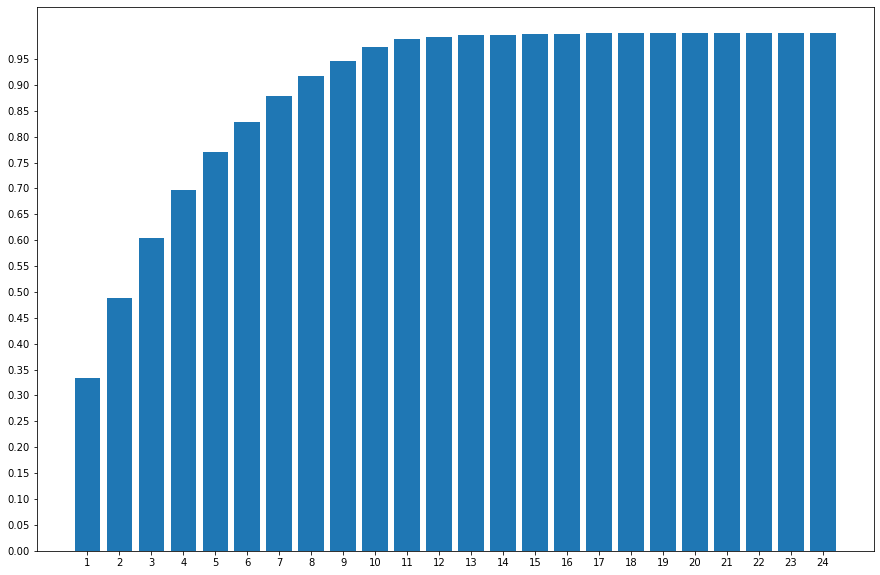

In [267]:
plt.figure(figsize=(15, 10))
plt.bar(range(1, pca.explained_variance_ratio_.shape[0] + 1), np.cumsum(pca.explained_variance_ratio_))
ax = plt.gca()
ax.set_yticks(np.arange(0, 1., 0.05))
ax.set_xticks(np.arange(1, 25, 1))
plt.show()

In [347]:
pca = PCA(n_components=5, whiten=False, random_state=2020)
npNArrPca = pca.fit_transform(pdDfSamples.iloc[:, 0:5].values)
pdDfInverse = pd.DataFrame(data=pca.inverse_transform(npNArrPca), index=pdDfSamples.index, \
   columns=pdDfSamples.iloc[:, 0:5].columns)
pdSeriesLoss = fn_anomalyScores(pdDfSamples.iloc[:, 0:5], pdDfInverse)

In [348]:
oKMeans = KMeans(n_clusters=2)
npNArrIndexes = oKMeans.fit_predict(npNArrPca[:, :])

In [355]:
np.sum(npNArrIndexes)

20878

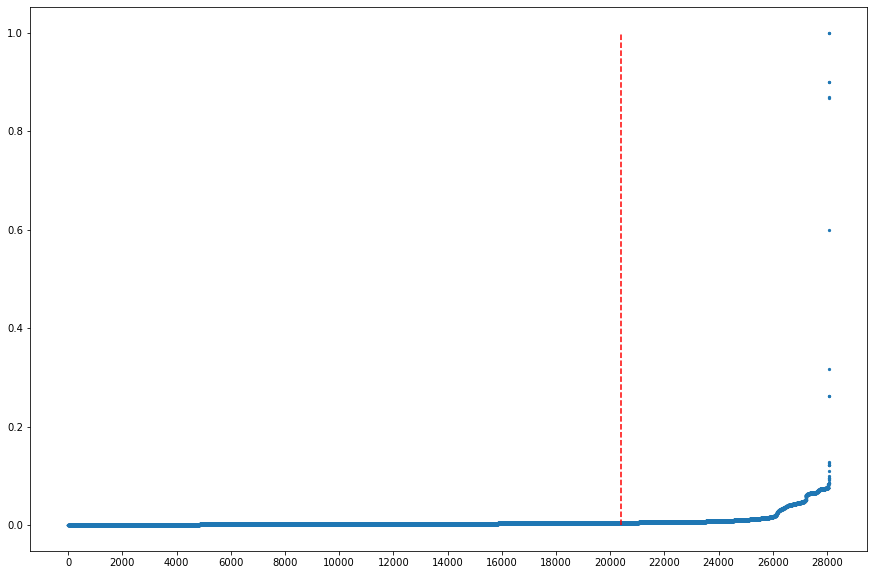

In [336]:
plt.figure(figsize=(15, 10))
plt.scatter(range(pdSeiresLoss.size), pdSeriesLoss.sort_values(), s=5)
ax = plt.gca()
_ = ax.set_xticks(range(0, pdSeiresLoss.size, 2000))
plt.vlines(20400, 0, 1, linestyles="--", colors="red")
plt.show()

In [337]:
fThreshold = pdSeiresLoss.sort_values()[20400]
pdDfLeftSamples = pdDfSamples.loc[pdSeiresLoss < fThreshold, :]
pdDfBadSamples = pdDfSamples.loc[pdSeiresLoss > fThreshold, :]

## 将剔除异常样本的正常训练样本划分为各个部分
存入各个部分对应的文件中，以部分名命名

In [338]:
"""
0-4 中频控制
5-6 中频输入
7-8 载波同步
9-13 比特同步
14-17 维特比译码
18-23 帧同步
"""
pdDfLeftSamples.iloc[:, 0:5].to_csv("../left/ifu.csv", index_label="id")
pdDfLeftSamples.iloc[:, 0:7].to_csv("../left/input.csv", index_label="id")
pdDfLeftSamples.iloc[:, 0:9].to_csv("../left/ifu.csv", index_label="id")
pdDfLeftSamples.iloc[:, 0:14].to_csv("../left/ifu.csv", index_label="id")
pdDfLeftSamples.iloc[:, 0:18].to_csv("../left/ifu.csv", index_label="id")
pdDfLeftSamples.iloc[:, :].to_csv("../left/ifu.csv", index_label="id")

# 译码部分
DPU_DECODEPOS为0则解扰在译码前、1则解扰在译码后。由于crc只能起到校验的作用，所以不管crc，只考虑ldpc和rs。ldpc和rs两者不会同时存在。目前打算用聚类的方法，将译码部分的记录分成正常和异常两部分，可能样本含量多的cluster代表正常样本、反之为异常样本。

DPU_SYNCTHRESHOLD2、DPU_CTLTHRESHOLD2、DPU_LTSTHRESHOLD2、DPU_BITSLIPWINDOW2这四个参数是在帧同步时需要设定的参数，但是在整个数据集里它们的值均为3。所以目前暂时不考虑它们。

## 载入数据
在parts下新建decode文件夹。译码也是分为两个通道进行的，所以要在decode下新建ch1和ch2文件夹